# FloPy

### Voronoi grid example

First set the path and import the required packages. The flopy path doesn't have to be set if you install flopy from a binary installer. If you want to run this notebook, you have to set the path to your own flopy path.

In [1]:
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy
from flopy.utils.triangle import Triangle as Triangle
from flopy.utils.voronoi import VoronoiGrid

workspace = os.path.join('data', 'voronoi')
# make sure workspace directory exists
if not os.path.exists(workspace):
    os.makedirs(workspace)

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.8.10 (default, May 19 2021, 11:01:55) 
[Clang 10.0.0 ]
numpy version: 1.20.3
matplotlib version: 3.4.2
flopy version: 3.3.5


### Use Triangle to Generate Points for Voronoi Grid

In [2]:
#set domain extents
xmin = 0.
xmax = 2000.
ymin = 0.
ymax = 1000.

#set minimum angle
angle_min = 30

#set maximum area
area_max = 1000.

delr = area_max ** 0.5
ncol = xmax / delr
nrow = ymax / delr
nodes = ncol * nrow
print('equivalent delr: ', delr)
print('equivalent nodes, ncol, nrow: ', int(nodes), ncol, nrow)

equivalent delr:  31.622776601683793
equivalent nodes, ncol, nrow:  2000 63.245553203367585 31.622776601683793


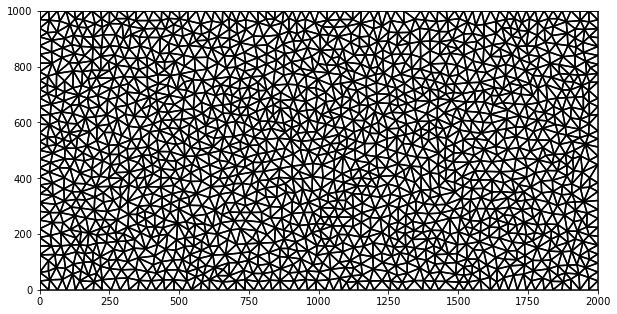

In [3]:
tri = Triangle(maximum_area=area_max, angle=angle_min, 
               model_ws=workspace)
poly = np.array(((xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)))
tri.add_polygon(poly)
tri.build(verbose=False)

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1, aspect='equal')
pc = tri.plot(ax=ax);

### Create and Plot FloPy Voronoi Grid

The Flopy VoronoiGrid class can be used to generate voronoi grids using the scipy.spatial.Voronoi class.  The VoronoiGrid class is a thin wrapper that makes sure edge cells are closed and provides methods for obtaining the information needed to make FloPy MODFLOW models.  It works by passing in the flopy Triangle object generated in the previous cell.

Number of triangular points 1692
Number of triangles 3198
Number of edges 4889
Number of voronoi vertices 3750
Number of voronoi cells 1692


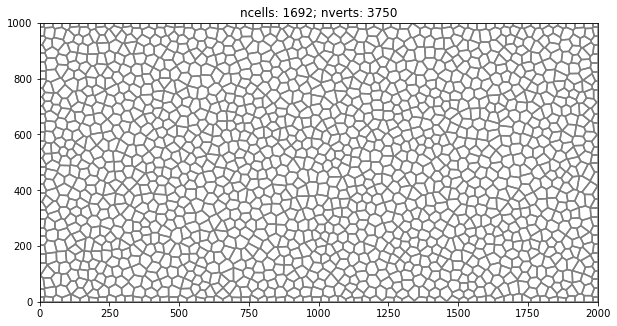

In [4]:
voronoi_grid = VoronoiGrid(tri)
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1, aspect='equal')
voronoi_grid.plot(ax=ax, facecolor='none');

### Use the VertexGrid Representation to Identify Boundary Cells

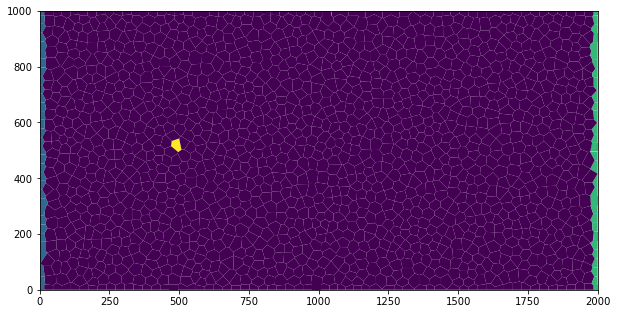

In [5]:
gridprops = voronoi_grid.get_gridprops_vertexgrid()
vgrid = flopy.discretization.VertexGrid(**gridprops, nlay=1)
ibd = np.zeros(vgrid.ncpl, dtype=int)
gi = flopy.utils.GridIntersect(vgrid)

# identify cells on left edge
line = LineString([(xmin, ymin), (xmin, ymax)])
cells0 = gi.intersect(line)['cellids']
cells0 = np.array(list(cells0))
ibd[cells0] = 1

# identify cells on right edge
line = LineString([(xmax, ymin), (xmax, ymax)])
cells1 = gi.intersect(line)['cellids']
cells1 = np.array(list(cells1))
ibd[cells1] = 2

# identify cell for a constant concentration condition
point = Point((500, 500))
cells2 = gi.intersect(point)['cellids']
cells2 = np.array(list(cells2))
ibd[cells2] = 3

if True:
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(1, 1, 1, aspect='equal')
    pmv = flopy.plot.PlotMapView(modelgrid=vgrid)
    pmv.plot_array(ibd)

### Create Run and Post Process a MODFLOW 6 Flow Model

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model mf...
    writing model name file...
    writing package disv...
    writing package npf...
    writing package ic...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 62 based on size of stress_period_data
    writing package oc...


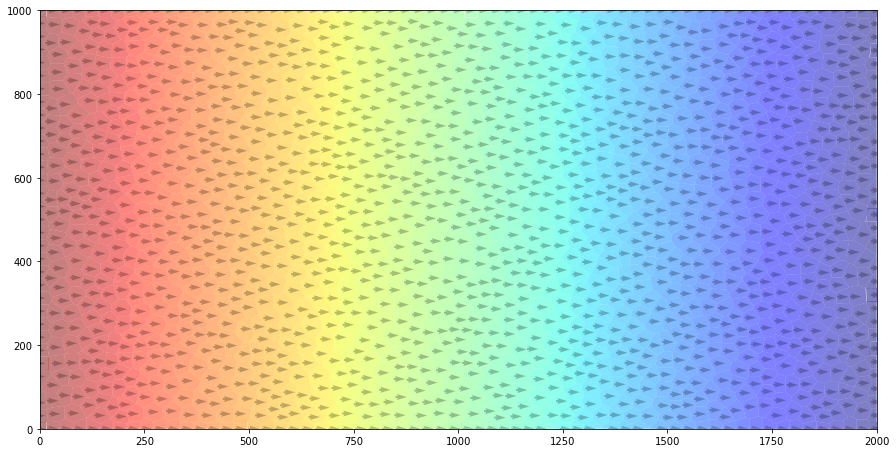

In [6]:
name = 'mf'
sim_ws = os.path.join(workspace, 'flow')
sim = flopy.mf6.MFSimulation(sim_name=name, version='mf6',
                             exe_name='mf6',
                             sim_ws=sim_ws)
tdis = flopy.mf6.ModflowTdis(sim, time_units='DAYS',
                             perioddata=[[1.0, 1, 1.]])
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, 
                           save_flows=True)
ims = flopy.mf6.ModflowIms(sim, print_option='SUMMARY', 
                           complexity='complex', 
                           outer_dvclose=1.e-8, 
                           inner_dvclose=1.e-8)
disv_gridprops = voronoi_grid.get_disv_gridprops()
nlay = 1
top = 1.
botm = [0.]
disv = flopy.mf6.ModflowGwfdisv(gwf, nlay=nlay, 
                                **disv_gridprops,
                                top=top, botm=botm)
npf = flopy.mf6.ModflowGwfnpf(gwf, xt3doptions=[(True)],
                              k=10.,
                              save_saturation=True,
                              save_specific_discharge=True)
ic = flopy.mf6.ModflowGwfic(gwf)

chdlist = []
for icpl in cells0:
    chdlist.append([(0, icpl), 1.])
for icpl in cells1:
    chdlist.append([(0, icpl), 0.])
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chdlist)
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord='{}.bud'.format(name),
                            head_filerecord='{}.hds'.format(name),
                            saverecord=[('HEAD', 'ALL'),
                                        ('BUDGET', 'ALL')],
                            printrecord=[('HEAD', 'LAST'),
                                         ('BUDGET', 'LAST')])
sim.write_simulation()
success, buff = sim.run_simulation(report=True, silent=True)

head = gwf.output.head().get_data()
bdobj = gwf.output.budget()
spdis = bdobj.get_data(text='DATA-SPDIS')[0]

fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 1, 1, aspect='equal')
pmv = flopy.plot.PlotMapView(gwf)
pmv.plot_array(head, cmap='jet', alpha=0.5)
pmv.plot_vector(spdis["qx"], spdis["qy"], alpha=.25);

### Create Run and Post Process a MODFLOW 6 Transport Model

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model mf...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package mst...
    writing package adv...
    writing package dsp...
    writing package ssm...
    writing package cnc-1...
    writing package fmi...
    writing package oc...


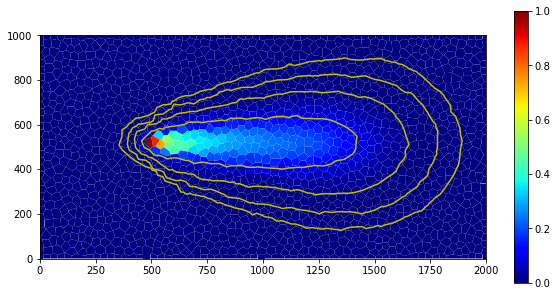

In [7]:
name = 'mf'
sim_ws = os.path.join(workspace, 'transport')
sim = flopy.mf6.MFSimulation(sim_name=name, version='mf6',
                             exe_name='mf6',
                             sim_ws=sim_ws)
tdis = flopy.mf6.ModflowTdis(sim, time_units='DAYS',
                             perioddata=[[100*365., 100, 1.]])
gwt = flopy.mf6.ModflowGwt(sim, modelname=name, save_flows=True)
ims = flopy.mf6.ModflowIms(sim, print_option='SUMMARY', 
                           complexity='simple',
                           linear_acceleration='bicgstab',
                           outer_dvclose=1.e-6, 
                           inner_dvclose=1.e-6)
disv_gridprops = voronoi_grid.get_disv_gridprops()
nlay = 1
top = 1.
botm = [0.]
disv = flopy.mf6.ModflowGwtdisv(gwt, nlay=nlay, 
                                **disv_gridprops,
                                top=top, botm=botm)
ic = flopy.mf6.ModflowGwtic(gwt, strt=0.)
sto = flopy.mf6.ModflowGwtmst(gwt, porosity=0.2)
adv = flopy.mf6.ModflowGwtadv(gwt, scheme='TVD')
dsp = flopy.mf6.ModflowGwtdsp(gwt, alh=5., ath1=0.5)
sourcerecarray = [()]
ssm = flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray)
cnclist = [[(0, cells2[0]), 1.],]
cnc = flopy.mf6.ModflowGwtcnc(gwt, maxbound=len(cnclist),
                              stress_period_data=cnclist,
                              pname='CNC-1')
pd = [('GWFHEAD', '../flow/mf.hds'),
    ('GWFBUDGET', '../flow/mf.bud'),]
fmi = flopy.mf6.ModflowGwtfmi(gwt, packagedata=pd)
oc = flopy.mf6.ModflowGwtoc(gwt,
                            budget_filerecord='{}.cbc'.format(name),
                            concentration_filerecord='{}.ucn'.format(
                                name),
                            saverecord=[('CONCENTRATION', 'ALL'),
                                        ('BUDGET', 'ALL')])

sim.write_simulation()
success, buff = sim.run_simulation(report=True, silent=True)

fname = os.path.join(sim_ws, name + '.ucn')
cobj = flopy.utils.HeadFile(fname, precision='double', 
                            text='CONCENTRATION')
conc = cobj.get_data()

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1, aspect='equal')
pmv = flopy.plot.PlotMapView(gwf)
c = pmv.plot_array(conc, cmap='jet')
pmv.contour_array(conc, levels=(.0001, .001, .01, .1), colors='y')
plt.colorbar(c, shrink=0.5);